# Installation

In [308]:
!pip install -U gensim

Requirement already up-to-date: gensim in d:\anconda\lib\site-packages (4.0.1)


In [309]:
!pip install yellowbrick

In [310]:
!pip install bert-for-tf2

In [311]:
!pip install tensorflow_hub

# To-do list

- corriger l'affichage des mots le plus communs dans un cluster
- regler l'affichage des matrice de confusions supervisé
- Créer le pipeline pour les modèles non-supervisés
- Commenter le code et expliquer les notations techniques comme le sillouhaite score

# Import

In [312]:
# import libraries
import numpy as np 
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import GridSearchCV
from nltk.stem.wordnet import WordNetLemmatizer
import sklearn.metrics as metrics
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from nltk import ngrams
from nltk import bigrams
from nltk import trigrams
import  collections
import gensim
from gensim.models import Word2Vec
from sklearn.metrics import silhouette_score,silhouette_samples
import matplotlib.cm as cm
from sklearn.feature_extraction.text import TfidfVectorizer

from yellowbrick.text import TSNEVisualizer
from yellowbrick.datasets import load_hobbies

import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

# import tensorflow as tf
# from tensorflow.keras.layers import Dense,Input, Dropout
# from tensorflow.keras.optimizers import Adam



In [313]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\princ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\princ\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [314]:
data = pd.read_csv("./data/flipkart_com-ecommerce_sample_1050.csv")
data.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."


In [315]:
corpus = data[['description']]
corpus.head(3)

,description
0,Key Features of Elegance Polyester Multicolor ...
1,Specifications of Sathiyas Cotton Bath Towel (...
2,Key Features of Eurospa Cotton Terry Face Towe...


In [316]:
corpus.shape

(1050, 1)

#  Récupération des catégories principales

In [317]:
data['main_cat'] = data.product_category_tree.str.split(">>",expand=True,)[0]
data.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,main_cat
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...","[""Home Furnishing"
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...","[""Baby Care"
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...","[""Baby Care"


In [318]:
data['main_cat'] = data['main_cat'].str.replace(r'"', '')
data['main_cat'] = data['main_cat'].str.replace(r'[', '')
data['main_cat'] = data['main_cat'].str.replace(r']', '')

<ipython-input-318-ae0145373f22>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  data['main_cat'] = data['main_cat'].str.replace(r'[', '')
<ipython-input-318-ae0145373f22>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  data['main_cat'] = data['main_cat'].str.replace(r']', '')


In [319]:
data['main_cat'].unique()

array(['Home Furnishing ', 'Baby Care ', 'Watches ',
       'Home Decor & Festive Needs ', 'Kitchen & Dining ',
       'Beauty and Personal Care ', 'Computers '], dtype=object)

# Data preprocessing

In [320]:
dataMini = data[['main_cat','description']]
dataMini

,main_cat,description
0,Home Furnishing,Key Features of Elegance Polyester Multicolor ...
1,Baby Care,Specifications of Sathiyas Cotton Bath Towel (...
2,Baby Care,Key Features of Eurospa Cotton Terry Face Towe...
3,Home Furnishing,Key Features of SANTOSH ROYAL FASHION Cotton P...
4,Home Furnishing,Key Features of Jaipur Print Cotton Floral Kin...
...,...,...
1045,Baby Care,Oren Empower Extra Large Self Adhesive Sticker...
1046,Baby Care,Wallmantra Large Vinyl Sticker Sticker (Pack o...
1047,Baby Care,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...
1048,Baby Care,Buy Wallmantra Medium Vinyl Sticker Sticker fo...


In [321]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [322]:
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [323]:
dataMini["text_clean"] = dataMini["description"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
dataMini.head()

<ipython-input-323-cfaf4699e1bc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataMini["text_clean"] = dataMini["description"].apply(lambda x:


,main_cat,description,text_clean
0,Home Furnishing,Key Features of Elegance Polyester Multicolor ...,key feature elegance polyester multicolor abst...
1,Baby Care,Specifications of Sathiyas Cotton Bath Towel (...,specification sathiyas cotton bath towel 3 bat...
2,Baby Care,Key Features of Eurospa Cotton Terry Face Towe...,key feature eurospa cotton terry face towel se...
3,Home Furnishing,Key Features of SANTOSH ROYAL FASHION Cotton P...,key feature santosh royal fashion cotton print...
4,Home Furnishing,Key Features of Jaipur Print Cotton Floral Kin...,key feature jaipur print cotton floral king si...


Créer une list de texte nettoyé pour entrainer les modèles non-supervisé

In [324]:
clean_desc = []
for w in range(len(dataMini.text_clean)):
    clean_desc.append(dataMini.text_clean.iloc[w])

In [325]:
clean_desc

['key feature elegance polyester multicolor abstract eyelet door curtain floral curtainelegance polyester multicolor abstract eyelet door curtain 213 cm height pack 2 price r 899 curtain enhances look interiorsthis curtain made 100 high quality polyester fabricit feature eyelet style stitch metal ringit make room environment romantic lovingthis curtain ant wrinkle anti shrinkage elegant apparancegive home bright modernistic appeal design surreal attention sure steal heart contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw close evening create special moment joyous beauty given soothing print bring home elegant curtain softly filter light room get right amount sunlightspecifications elegance polyester multicolor abstract eyelet door curtain 213 cm height pack 2 general brand elegance designed door type eyelet model name abstract polyester door curtain set 2 model id duster25 color multicolor di

## Split dataset

Nous allons diviser le jeu de données en deux partie (train et test) pour les modèle machine learning supervisé

In [326]:
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing

## split dataset
dtf_train, dtf_test = model_selection.train_test_split(dataMini, test_size=0.3)
## get target
y_train = dtf_train["main_cat"].values
y_test = dtf_test["main_cat"].values

# N-gram

In [327]:
# generate unigrams bigrams trigrams

unigram=[]
bigram=[]
trigram=[]
tokenized_text=[]

for sentence in dataMini['text_clean']:
    unigram.extend(unigram)
    bigram.extend(bigrams(sentence.split(' ')))
    trigram.extend(trigrams(sentence.split(' ')))

In [328]:
bigramFreq = collections.Counter(bigram)
bigramFreq

Counter({('key', 'feature'): 207,
         ('feature', 'elegance'): 1,
         ('elegance', 'polyester'): 2,
         ('polyester', 'multicolor'): 4,
         ('multicolor', 'abstract'): 3,
         ('abstract', 'eyelet'): 4,
         ('eyelet', 'door'): 14,
         ('door', 'curtain'): 26,
         ('curtain', 'floral'): 1,
         ('floral', 'curtainelegance'): 1,
         ('curtainelegance', 'polyester'): 1,
         ('curtain', '213'): 4,
         ('213', 'cm'): 9,
         ('cm', 'height'): 22,
         ('height', 'pack'): 12,
         ('pack', '2'): 61,
         ('2', 'price'): 15,
         ('price', 'r'): 342,
         ('r', '899'): 5,
         ('899', 'curtain'): 1,
         ('curtain', 'enhances'): 1,
         ('enhances', 'look'): 1,
         ('look', 'interiorsthis'): 1,
         ('interiorsthis', 'curtain'): 1,
         ('curtain', 'made'): 1,
         ('made', '100'): 8,
         ('100', 'high'): 2,
         ('high', 'quality'): 69,
         ('quality', 'polyester'): 3,

In [329]:
trigramFreq = collections.Counter(trigram)
trigramFreq

Counter({('key', 'feature', 'elegance'): 1,
         ('feature', 'elegance', 'polyester'): 1,
         ('elegance', 'polyester', 'multicolor'): 2,
         ('polyester', 'multicolor', 'abstract'): 3,
         ('multicolor', 'abstract', 'eyelet'): 3,
         ('abstract', 'eyelet', 'door'): 3,
         ('eyelet', 'door', 'curtain'): 14,
         ('door', 'curtain', 'floral'): 1,
         ('curtain', 'floral', 'curtainelegance'): 1,
         ('floral', 'curtainelegance', 'polyester'): 1,
         ('curtainelegance', 'polyester', 'multicolor'): 1,
         ('door', 'curtain', '213'): 4,
         ('curtain', '213', 'cm'): 4,
         ('213', 'cm', 'height'): 4,
         ('cm', 'height', 'pack'): 12,
         ('height', 'pack', '2'): 7,
         ('pack', '2', 'price'): 11,
         ('2', 'price', 'r'): 15,
         ('price', 'r', '899'): 5,
         ('r', '899', 'curtain'): 1,
         ('899', 'curtain', 'enhances'): 1,
         ('curtain', 'enhances', 'look'): 1,
         ('enhances', 'loo

# Features extraction

## TF-IDF

In [330]:
tf_vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,3))

## bag of words

In [331]:
## Count (classic BoW)
bow_vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,3))

## BERT

In [332]:
# import tensorflow_hub as hub

# # module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
# module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"

# bert_layer = hub.KerasLayer(module_url, trainable=True)

In [333]:
import numpy as np

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

## Doc2vec

In [334]:
tokenized_sent = []
for s in dataMini['text_clean']:
    tokenized_sent.append(word_tokenize(s.lower()))

In [335]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_sent)]
tagged_data

[TaggedDocument(words=['key', 'feature', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtainelegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', '213', 'cm', 'height', 'pack', '2', 'price', 'r', '899', 'curtain', 'enhances', 'look', 'interiorsthis', 'curtain', 'made', '100', 'high', 'quality', 'polyester', 'fabricit', 'feature', 'eyelet', 'style', 'stitch', 'metal', 'ringit', 'make', 'room', 'environment', 'romantic', 'lovingthis', 'curtain', 'ant', 'wrinkle', 'anti', 'shrinkage', 'elegant', 'apparancegive', 'home', 'bright', 'modernistic', 'appeal', 'design', 'surreal', 'attention', 'sure', 'steal', 'heart', 'contemporary', 'eyelet', 'valance', 'curtain', 'slide', 'smoothly', 'draw', 'apart', 'first', 'thing', 'morning', 'welcome', 'bright', 'sun', 'ray', 'want', 'wish', 'good', 'morning', 'whole', 'world', 'draw', 'close', 'evening', 'create', 'special', 'moment', 'joyous', 'beauty', 'given', 'soothing', 'print'

In [336]:
model = Doc2Vec(tagged_data, vector_size = 20, window = 2, min_count = 1, epochs = 100)

'''
vector_size = Dimensionality of the feature vectors.
window = The maximum distance between the current and predicted word within a sentence.
min_count = Ignores all words with total frequency lower than this.
alpha = The initial learning rate.
'''

## Print model vocabulary
words = list(model.wv.index_to_key)

In [337]:
words

['product',
 'free',
 'r',
 'buy',
 'delivery',
 'cash',
 'genuine',
 'shipping',
 'price',
 'replacement',
 'day',
 'cm',
 '30',
 'flipkartcom',
 'guarantee',
 'mug',
 '1',
 'feature',
 'online',
 'watch',
 'color',
 'type',
 'baby',
 'pack',
 'material',
 'set',
 'box',
 'general',
 'cotton',
 'package',
 'sale',
 'design',
 'analog',
 'number',
 'warranty',
 'detail',
 'quality',
 'girl',
 'brand',
 'laptop',
 'best',
 'key',
 'inch',
 'model',
 'ceramic',
 'showpiece',
 'fabric',
 'size',
 'great',
 'made',
 'perfect',
 'boy',
 'gift',
 'india',
 'men',
 'dimension',
 'usb',
 '2',
 'skin',
 'home',
 'ideal',
 'multicolor',
 'specification',
 'content',
 'one',
 'combo',
 'cover',
 'light',
 'woman',
 'water',
 'x',
 'print',
 'printed',
 'discount',
 'adapter',
 'width',
 'wash',
 'black',
 'battery',
 'give',
 'also',
 'care',
 'power',
 'ml',
 '4',
 'coffee',
 'height',
 'yes',
 'pattern',
 'high',
 '6',
 'style',
 'use',
 '3',
 'blue',
 'length',
 'towel',
 'name',
 'come',
 'ea

In [338]:
test_doc = word_tokenize("I had pizza and pasta".lower())
test_doc_vector = model.infer_vector(test_doc)
model.docvecs.most_similar(positive = [test_doc_vector])

<ipython-input-338-4a3c7f85d5c6>:3: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  model.docvecs.most_similar(positive = [test_doc_vector])


[(218, 0.827113151550293),
 (193, 0.8202250003814697),
 (657, 0.8177435994148254),
 (235, 0.8167452216148376),
 (223, 0.8156582713127136),
 (216, 0.8084284067153931),
 (199, 0.8042641878128052),
 (890, 0.7704768180847168),
 (163, 0.764374852180481),
 (215, 0.7634148597717285)]

# Create train corpus

In [339]:
def createInput(vectorizer):
    corpus = dtf_train["text_clean"]
    vectorizer.fit(corpus)
    X_train = vectorizer.transform(corpus)
    return X_train

# Classifieurs

In [340]:
classifier = naive_bayes.MultinomialNB()

In [341]:
kmeans = KMeans(n_clusters = 7, n_init = 17, n_jobs = -1, tol = 0.01, max_iter = 200)
def cluster_kmeans(vect):
    #setup kmeans clustering
    #fit the data 
    kmeans.fit(vect)
    #this loop transforms the numbers back into words
    common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
#     for num, centroid in enumerate(common_words):
#         print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))
    print(enumerate(common_words))

# Pipeline

## Modèles supervisés

In [342]:
def createPipeline(classifier,vectorizer):
    ## pipeline
    model = pipeline.Pipeline([("vectorizer", vectorizer),  
                               ("classifier", classifier)])
    ## Create X_train 
    X_train = createInput(vectorizer)
    
    ## train classifier
    model["classifier"].fit(X_train, y_train)
    
    ## test
    X_test = dtf_test["text_clean"].values
    predicted = model.predict(X_test)
    return predicted

Nous allons créer des pipeline pour tous les extracteur de features :

In [343]:
tf_predicted = createPipeline(classifier,tf_vectorizer)

In [344]:
bow_predicted = createPipeline(classifier,bow_vectorizer)

## Modèles non-supervisés

In [345]:
vec_tfidf = tf_vectorizer.fit_transform(clean_desc)

In [346]:
cluster_kmeans(vec_tfidf)

D:\Anconda\lib\site-packages\sklearn\cluster\_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


In [347]:
dataMini['cluster_tfidf_kmeans'] = kmeans.labels_

<ipython-input-347-4cd43be8d624>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataMini['cluster_tfidf_kmeans'] = kmeans.labels_


In [348]:
bow = bow_vectorizer.fit_transform(clean_desc)

In [349]:
cluster_kmeans(bow)

D:\Anconda\lib\site-packages\sklearn\cluster\_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


In [350]:
dataMini['cluster_bow_kmeans'] = kmeans.labels_

<ipython-input-350-650b4a050c5d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataMini['cluster_bow_kmeans'] = kmeans.labels_


In [351]:
dataMini.head(3)

,main_cat,description,text_clean,cluster_tfidf_kmeans,cluster_bow_kmeans
0,Home Furnishing,Key Features of Elegance Polyester Multicolor ...,key feature elegance polyester multicolor abst...,2,2
1,Baby Care,Specifications of Sathiyas Cotton Bath Towel (...,specification sathiyas cotton bath towel 3 bat...,2,2
2,Baby Care,Key Features of Eurospa Cotton Terry Face Towe...,key feature eurospa cotton terry face towel se...,2,2


# Evolution de performance

## Précision et recall

In [352]:
def calcul_performance(predicted):
    classes = np.unique(y_test)
    y_test_array = pd.get_dummies(y_test, drop_first=False).values

    accuracy = metrics.accuracy_score(y_test, predicted)
    print("Accuracy:",  round(accuracy,2))
    print("Detail:")
    print(metrics.classification_report(y_test, predicted))

Nous allons evoluer la performance de classifier avec chacun d'extracteur de feature

In [353]:
calcul_performance(tf_predicted)

Accuracy: 0.9
Detail:
                             precision    recall  f1-score   support

                 Baby Care        0.78      0.64      0.71        45
  Beauty and Personal Care        0.93      0.93      0.93        42
                 Computers        0.94      1.00      0.97        45
Home Decor & Festive Needs        0.86      0.93      0.90        46
           Home Furnishing        0.78      0.91      0.84        46
          Kitchen & Dining        1.00      0.85      0.92        47
                   Watches        1.00      1.00      1.00        44

                   accuracy                           0.90       315
                  macro avg       0.90      0.90      0.89       315
               weighted avg       0.90      0.90      0.89       315



In [354]:
calcul_performance(bow_predicted)

Accuracy: 0.85
Detail:
                             precision    recall  f1-score   support

                 Baby Care        0.93      0.62      0.75        45
  Beauty and Personal Care        0.66      0.93      0.77        42
                 Computers        0.92      0.73      0.81        45
Home Decor & Festive Needs        0.82      0.91      0.87        46
           Home Furnishing        0.77      1.00      0.87        46
          Kitchen & Dining        1.00      0.74      0.85        47
                   Watches        1.00      1.00      1.00        44

                   accuracy                           0.85       315
                  macro avg       0.87      0.85      0.85       315
               weighted avg       0.87      0.85      0.85       315



## Matrice de confusion 

### Modèles supervisés

In [355]:
def createConfusionMatrix(predicted):
    classes = np.unique(y_test)

    ## Plot confusion matrix
    cm = metrics.confusion_matrix(y_test, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
           yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)
    plt.xticks(rotation=30)

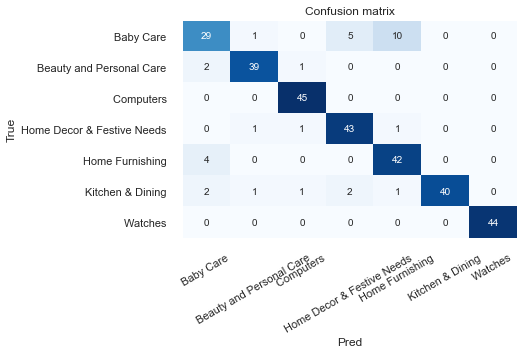

In [356]:
createConfusionMatrix(tf_predicted)

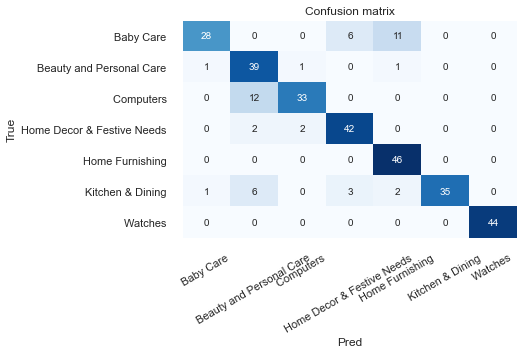

In [357]:
createConfusionMatrix(bow_predicted)

### Modèles non-supervisés

In [358]:
dataReduced = dataMini[['main_cat','cluster_tfidf_kmeans','cluster_bow_kmeans']]
dataReduced.head(3)

,main_cat,cluster_tfidf_kmeans,cluster_bow_kmeans
0,Home Furnishing,2,2
1,Baby Care,2,2
2,Baby Care,2,2


In [359]:
dataReduced.main_cat.unique()

array(['Home Furnishing ', 'Baby Care ', 'Watches ',
       'Home Decor & Festive Needs ', 'Kitchen & Dining ',
       'Beauty and Personal Care ', 'Computers '], dtype=object)

In [360]:
tmp_data = dataReduced[[ 'main_cat','cluster_bow_kmeans']]
tmp_data

,main_cat,cluster_bow_kmeans
0,Home Furnishing,2
1,Baby Care,2
2,Baby Care,2
3,Home Furnishing,2
4,Home Furnishing,2
...,...,...
1045,Baby Care,2
1046,Baby Care,2
1047,Baby Care,4
1048,Baby Care,4


In [361]:
def create_confiuson_matrix(data, features_extrater):
    
    #Keep only the cluster of the required extrater

    tmp_data = dataReduced[[ 'main_cat',features_extrater]]    
    
    #Handle the categorical features
    dummy = pd.get_dummies(tmp_data['main_cat'])
    
    tmp_data = pd.concat([tmp_data,dummy],axis= 1)
    
    tmp_data.drop('main_cat',axis = 1 , inplace = True)
    
    confusion_matrix = tmp_data.groupby([features_extrater]).sum()
    return confusion_matrix

In [362]:
tfidf_confusin_matrix = create_confiuson_matrix(dataReduced,'cluster_tfidf_kmeans')

<AxesSubplot:ylabel='cluster_tfidf_kmeans'>

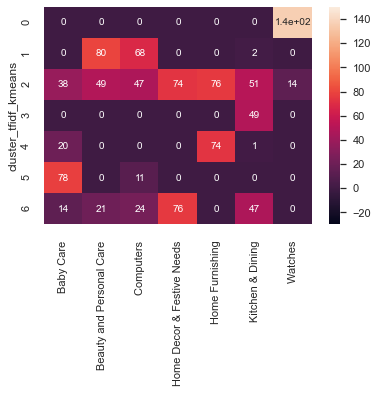

In [363]:
sns.heatmap(tfidf_confusin_matrix, annot=True, vmin=-30, vmax=150)

In [364]:
bow_confusin_matrix = create_confiuson_matrix(dataReduced,'cluster_bow_kmeans')

<AxesSubplot:ylabel='cluster_bow_kmeans'>

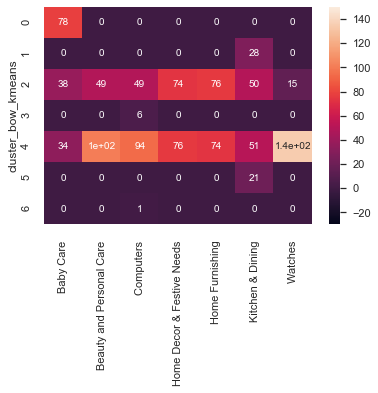

In [365]:
sns.heatmap(bow_confusin_matrix, annot=True, vmin=-30, vmax=150)

In [366]:
columnsTitles = ['Watches','Kitchen & Dining','Beauty and Personal Care','']

tfidf_confusin_matrix = tfidf_confusin_matrix.reindex(columns=columnsTitles)
tfidf_confusin_matrix

,Watches,Kitchen & Dining,Beauty and Personal Care,
cluster_tfidf_kmeans,,,,
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN


## Adjusted Rand Index

In [367]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(y_test, tf_predicted)

0.783926938747813

In [368]:
adjusted_rand_score(y_test, bow_predicted)

0.6879286722667596

# Sillouhaite Score Analysis

In [375]:
X= tf_vectorizer.fit_transform(dataMini['text_clean'])
X

<1050x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 77566 stored elements in Compressed Sparse Row format>

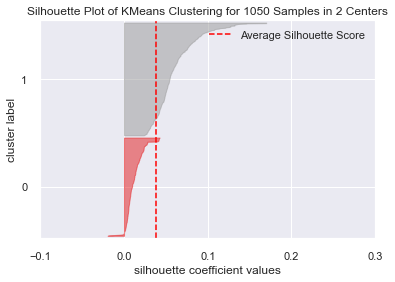

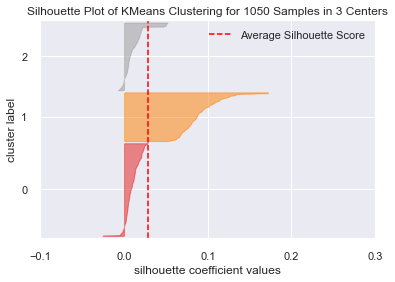

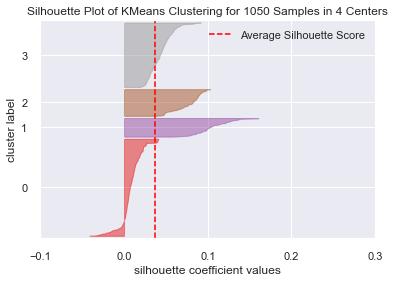

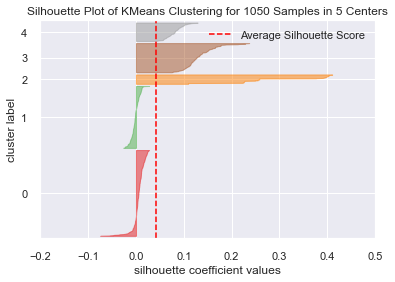

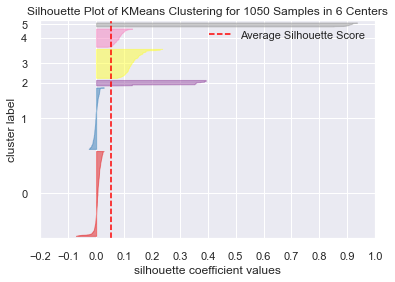

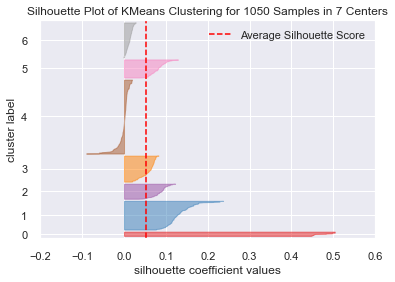

In [376]:
from yellowbrick.cluster import SilhouetteVisualizer

wcss = []

for i in range(2,8):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter= 300, random_state= 42)
    visualizer = SilhouetteVisualizer(kmeans)
    visualizer.fit(X)
    visualizer.show()
    wcss.append(kmeans.inertia_)   

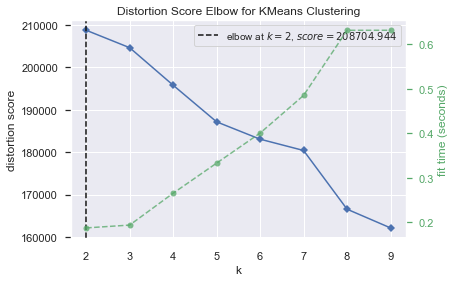

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [371]:
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(kmeans, k=(2,10))
 
visualizer.fit(X)
visualizer.show()   

# T-SNE

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

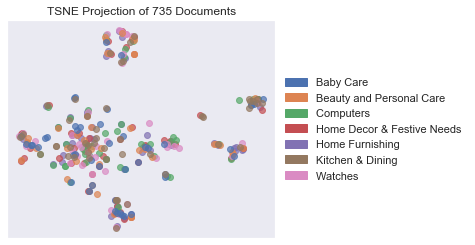

<AxesSubplot:title={'center':'TSNE Projection of 735 Documents'}>

In [372]:
X = createInput(tf_vectorizer)

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(X, y_test)
tsne.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

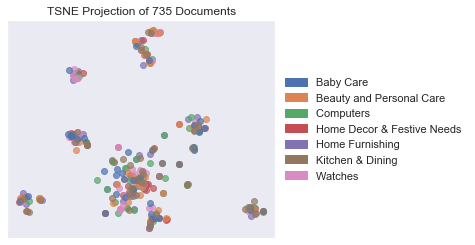

<AxesSubplot:title={'center':'TSNE Projection of 735 Documents'}>

In [373]:
X = createInput(bow_vectorizer)

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(X, y_test)
tsne.show()